In [ ]:
data = read_gem('F:\WuKong\wukong\SS200000135TL_D1.tissue.gem\SS200000135TL_D1.tissue.gem', bin_size=50)

In [3]:
df = pd.read_csv(str('F:\Adult.gem'), sep='\t', comment='#', header=0)

In [ ]:
plt.figure(figsize=(200, 200))
ax = sns.histplot(count, x='x', y='y', cbar=True, binwidth=10)
ax.invert_yaxis()

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.stats import wasserstein_distance


def cos_similarity_distance(x, y):
    '''Culculate the cosin similarity distance'''
    if x.shape != y.shape:
        raise ValueError('x and y must have same dimensions.')
    x = np.array(x)
    y = np.array(y)
    return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


def sub_index(center_index, distance, edge_index=0):
    return center_index - distance if center_index - distance > edge_index else edge_index


def add_index(center_index, distance, edge_index):
    return center_index + distance + 1 if center_index + distance <= edge_index else edge_index


def get_surround_matrix(matrix, index, distance):
    '''Get the surrounding matrix by index'''
    if distance < 1:
        raise ValueError("The value of distance must be larger than 0")
    row_edge = matrix.shape[0]
    col_edge = matrix.shape[1]
    row_index = index[0]
    col_index = index[1]
    return matrix[sub_index(row_index, distance): add_index(row_index, distance, row_edge),
                  sub_index(col_index, distance): add_index(col_index, distance, col_edge)]


def merge_bin_coor(coor: np.ndarray, coor_min: int, bin_size: int):
    return np.floor((coor - coor_min) / bin_size).astype(np.int)


def get_bin_center(bin_coor: np.ndarray, coor_min: int, bin_size: int):
    return bin_coor * bin_size + coor_min + int(bin_size / 2)


def get_coor_matrix(df):
    count = df.loc[:, ['x', 'y', 'MIDCounts']].groupby(
        ['x', 'y'], as_index=False).sum('MIDCounts')
    merge_count = 20
    bins = [np.array(range(count['x'].min(), count['x'].max()+merge_count, merge_count)),
            np.array(range(count['y'].min(), count['y'].max()+merge_count, merge_count))]
    H, xedges, yedges = np.histogram2d(x=count['x'],
                                       y=count['y'],
                                       weights=count['MIDCounts'],
                                       bins=bins)
    return H


def find_track(df):
    H = get_coor_matrix(df)
    # culculate col
    col_total = []
    for i in range(1, H.shape[1]-1):
        dis_1 = wasserstein_distance(H[:, i], H[:, i+1])
        dis_2 = wasserstein_distance(H[:, i], H[:, i-1])
        wd_average = (dis_1 + dis_2)/2
        col_total.append(wd_average)
    # culculate row
    row_total = []
    for i in range(1, H.shape[0]-1):
        dis_1 = wasserstein_distance(H[i, :], H[i+1, :])
        dis_2 = wasserstein_distance(H[i, :], H[i-1, :])
        wd_average = (dis_1 + dis_2)/2
        row_total.append(wd_average)
    return {'row': row_total, 'col': col_total}


def filter_track():
    pass


def fill_track(track_matrix):
    '''
    track_matrix: A matrix containing track locations with value of 1
    '''
    shape = track_matrix.shape
    matrix = csr_matrix(np.zeros(shape))


def find_undersampled_pixel(H, distance):
    bad_matrix = np.zeros(H.shape)
    for index, value in np.ndenumerate(H):
        surround_matrix = get_surround_matrix(H, index, distance)
        if (surround_matrix.mean() * 0.2 > value) & (surround_matrix.shape[0] == surround_matrix.shape[1]) & (np.median(surround_matrix) > 0) & (value > 0):
            bad_matrix[index[0], index[1]] = 1
    return bad_matrix
    



In [52]:
import numpy as np
from scipy.sparse import csr_matrix

a = csr_matrix(np.zeros((2, 3)))
a[1,1] = 2
print(a.toarray())
print("-"*15)
print(a)


[[0. 0. 0.]
 [0. 2. 0.]]
---------------
  (1, 1)	2.0


In [10]:
row_edge = H.shape[0]
col_edge = H.shape[1]
bad_matrix = np.zeros(H.shape)
bad_spots = np.array([])

for index, value in np.ndenumerate(H):
    tmp = get_surround_matrix(H, index, 15)
    if (tmp.mean() * 0.2 > value) & (tmp.shape[0] == tmp.shape[1]) & (np.median(tmp) > 0) & (value>0):
        bad_matrix[index[0], index[1]] = 1


<AxesSubplot:>

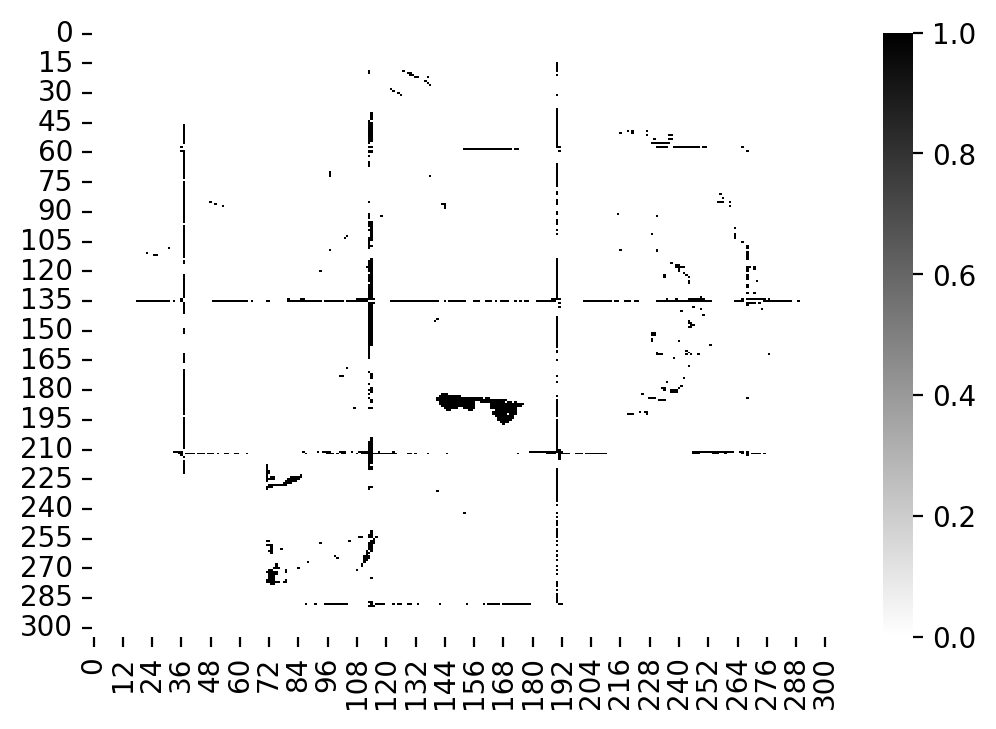

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(dpi=200)
sns.heatmap(bad_matrix, cmap = sns.blend_palette(['white','black'], as_cmap=True))

<AxesSubplot:>

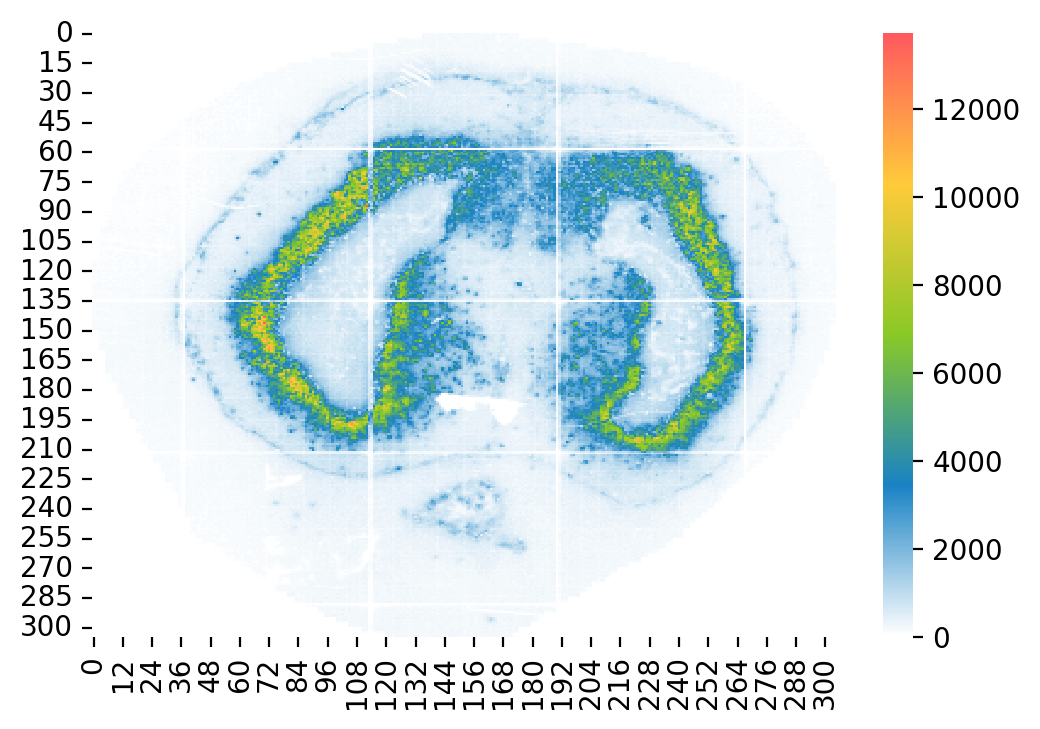

In [147]:
plt.figure(dpi=200)
sns.heatmap(H, cmap=sns.blend_palette(['white',
                                       '#1982C4',
                                       '#8AC926',
                                       '#FFCA3A',
                                       '#FF595E'], as_cmap=True))


In [199]:
from sklearn.neighbors import NearestNeighbors
samples = [[0, 0, 9], [0, 1, 6], [0, 2, 20], [1, 0, 18], [1, 1, 24], [1, 2, 20]]
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(samples)

print(neigh.kneighbors([[2, 0, 16]]))


(array([[2.23606798]]), array([[3]], dtype=int64))


In [212]:
from scipy.spatial import distance

samples = [[0, 0, 9], [0, 1, 6], [0, 2, 20], [1, 0, 18], [1, 1, 24], [1, 2, 20]]
for i in samples:
    print(distance.cosine([1, 1, 9], i))



0.012121660092786923
0.007517674845512912
0.006102360304856114
0.007554018156787579
0.004701090564820154
0.0018759228632408975


In [ ]:
x = [0, 0, 9]
y = [1, 1, 9, 2]
cos_similarity_distance(x, y)


In [263]:
a = [[1, 2, 3], [4, 5, 6]]
a = np.array(a, dtype='float')
a[:, 2] = a[:, 2] * 0.01
np.r_[a, [[8,8,8]]]
a


array([[1.  , 2.  , 0.03],
       [4.  , 5.  , 0.06]])

In [27]:
from scipy import sparse
import numpy as np

samples = np.array([[2, 0, 9], [0, 1, 6], [0, 2, 0], [1, 0, 1], [1, 1, 2], [1, 2, 1]])

csr = sparse.csr_matrix(samples)
print(csr)

  (0, 0)	2
  (0, 2)	9
  (1, 1)	1
  (1, 2)	6
  (2, 1)	2
  (3, 0)	1
  (3, 2)	1
  (4, 0)	1
  (4, 1)	1
  (4, 2)	2
  (5, 0)	1
  (5, 1)	2
  (5, 2)	1


In [36]:
from wukong.io import read_gem

In [37]:
data = read_gem('F:\WuKong\wukong\SS200000135TL_D1.tissue.gem\SS200000135TL_D1.tissue.gem', bin_size=50)

[INFO][2022-11-28 16:08:10] the matrix has 35899 cells, and 20816 genes.


In [38]:
data.get_genes_expressions()

<35899x20816 sparse matrix of type '<class 'numpy.intc'>'
	with 7044386 stored elements in Compressed Sparse Row format>

C:\Users\pssun\AppData\Local\Temp\ipykernel_8712\1558322422.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
f:\conda\lib\site-packages\matplotlib\collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


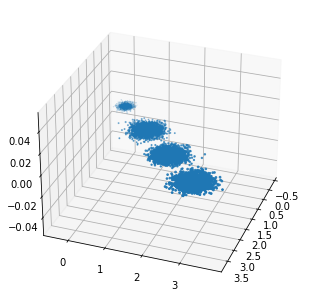

In [48]:
from sklearn.decomposition import PCA
from sklearn.datasets._samples_generator import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x, y = make_blobs(n_samples=10000,
                  n_features=3,
                  centers=[[3, 3, 3], [0, 0, 0], [1, 1, 1, ], [2, 2, 2]],
                  random_state=9,
                  cluster_std=[.2, .1, .2, .2])
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
plt.scatter(x[:,0],x[:,1],x[:,2])

In [51]:
pca = PCA(n_components=2)
pca.fit(x)
new = pca.transform(x)


In [72]:
x = np.array([[3, 2, 3, 15, 2], [0, 1, 1, 2, 99], [1, 11, 1, 8, 2], [8, 10, 26, 2, 2]])
r = pca.fit_transform(x)


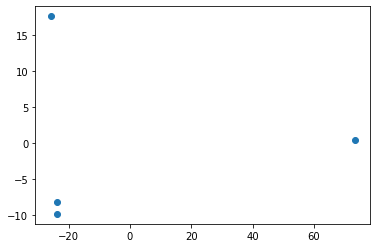

In [73]:
plt.scatter(r[:,0],r[:,1])

In [ ]:
bin_size = 20
x_min = df['x'].min()
y_min = df['y'].min()
df['bin_x'] = merge_bin_coor(df['x'].values, x_min, bin_size)
df['bin_y'] = merge_bin_coor(df['y'].values, y_min, bin_size)
df['x_center'] = get_bin_center(df['bin_x'], x_min, bin_size)
df['y_center'] = get_bin_center(df['bin_y'], y_min, bin_size)
df['cell_id'] = df['bin_x'].astype(str) + '_' + df['bin_y'].astype(str)

In [118]:
cells = df['cell_id'].unique()
genes = df['geneID'].unique()
cells_dict = dict(zip(cells, range(0, len(cells))))
genes_dict = dict(zip(genes, range(0, len(genes))))

In [149]:
from scipy.sparse import csr_matrix
if 'MIDCounts' in df.columns:
    df.rename(columns={'MIDCounts': 'UMICount'}, inplace=True)
elif 'MIDCount' in df.columns:
    df.rename(columns={'MIDCount': 'UMICount'}, inplace=True)
rows = df['cell_id'].map(cells_dict)
cols = df['geneID'].map(genes_dict)

In [151]:
exp = csr_matrix((df['UMICount'], (rows, cols)),
                 shape=(cells.shape[0], genes.shape[0]),
                 dtype=np.int32)


<71998x33149 sparse matrix of type '<class 'numpy.intc'>'
	with 31124594 stored elements in Compressed Sparse Row format>

In [188]:
print(exp[1,:].toarray().shape)


(1, 33149)


In [200]:
pca = PCA(n_components=10, svd_solver='arpack', random_state=0)
new = pca.fit_transform(exp.toarray())


f:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

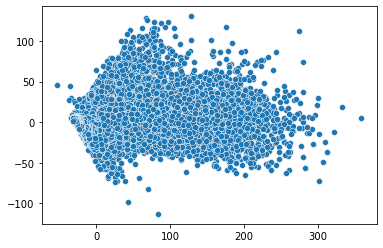

In [213]:
sns.scatterplot(new[:,0], new[:,4])

In [210]:
exp.toarray().shape

(71998, 33149)